In [33]:
# Ensure correct environment for GPy
import numpy, os, signal
if numpy.__version__ != "1.26.4":
    # 1. Uninstall conflicting packages
    !pip uninstall -y jax scipy jaxlib paramz pytensor > /dev/null 2>&1
    # 2. Install the versions required for GPy
    !pip install --force-reinstall numpy==1.26.4 scipy GPy paramz > /dev/null 2>&1
    # 3. Restart runtime to load correct NumPy ABI
    os.kill(os.getpid(), signal.SIGKILL)

!wget -q https://mlg.eng.cam.ac.uk/teaching/4f13/2526/cw/cw1a.mat > /dev/null
!wget -q https://mlg.eng.cam.ac.uk/teaching/4f13/2526/cw/cw1e.mat > /dev/null
!wget -q https://raw.githubusercontent.com/cambridge-mlg/4f13-courseworks/refs/heads/main/2526/cw1/gp.py > /dev/null

In [34]:
import GPy
import numpy as np
import gp as cw1utils

In [35]:
### Arbitrary data, X and y
X = np.random.rand(20, 1) * 10  # 20 data points in 1D
y = np.sin(X) + (np.cos(X))**2 + np.random.randn(20, 1) * 0.5  # noisy opipbservations

## Loading Matlab arrays in Python

In [36]:
import scipy.io as sio

In [37]:
data = sio.loadmat("cw1a.mat")  # Note this will throw an error because the file does not exist!

X = np.asarray(data["x"], dtype=float)
y = np.asarray(data["y"], dtype=float)

## GP Model Definition with Various Kernels (using GPy):

### Single kernels

Squared exponential (SE) isotropic

In [38]:
k = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)
m.likelihood.variance = 1.0  # Note that this is the default value, so we don't strictly need to set it here unless we want a different initial value.

Periodic

In [39]:
k = GPy.kern.StdPeriodic(input_dim=X.shape[1], lengthscale=1.0, period=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)

SE Automatic Relevance Determination (ARD)

In [40]:
k = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)

### Combined kernels

Product of Periodic and SE Isotropic

In [41]:
k_per = GPy.kern.StdPeriodic(input_dim=X.shape[1], lengthscale=1.0, period=1.0, variance=1.0)
k_se  = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=1.0, variance=1.0)
kernel = k_per * k_se
m = GPy.models.GPRegression(X, y, kernel)

Sum of two SE ARD Kernels

In [42]:
z = np.random.randn(4)
ell1 = np.exp(z[0])
sf1  = np.exp(z[1])
var1 = sf1**2

ell2 = np.exp(z[2])
sf2  = np.exp(z[3])
var2 = sf2**2

k1 = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=ell1, variance=var1)
k2 = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=ell2, variance=var2)
k  = k1 + k2

m = GPy.models.GPRegression(X, y, kernel=k)

## GP Model Hyperparameter Optimisation using Marginal Likelihood

Once a GP regression model is specified, we can optimise its hyperparameters by minimising the negative log marginal likelihood (which is equivalent to maximising the likelihood of the data under the model.)

In [43]:
m.optimize(optimizer='lbfgsb', max_iters=2000, messages=False)

 /usr/local/lib/python3.12/dist-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /usr/local/lib/python3.12/dist-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /usr/local/lib/python3.12/dist-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /usr/local/lib/python3.12/dist-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply


## Utilities functions useful for producing figures to be included in report

MODEL SUMMARY
NEGATIVE LOG MARGINAL LIKELIHOOD: 10.4955
OPTIMISED HYPERPARAMETERS:
    Component 1:
      • lengthscale (ℓ): 0.119463
      • signal std (σ_f): 0.771633
    Component 2:
      • lengthscale (ℓ): 10805.2
      • signal std (σ_f): 0.466702
    Noise std (σ_n): 0.117676
LML: -10.495453
  • Data fit term: -37.499776
  • Complexity penalty: -95.924713
  • Constant term: -68.920390


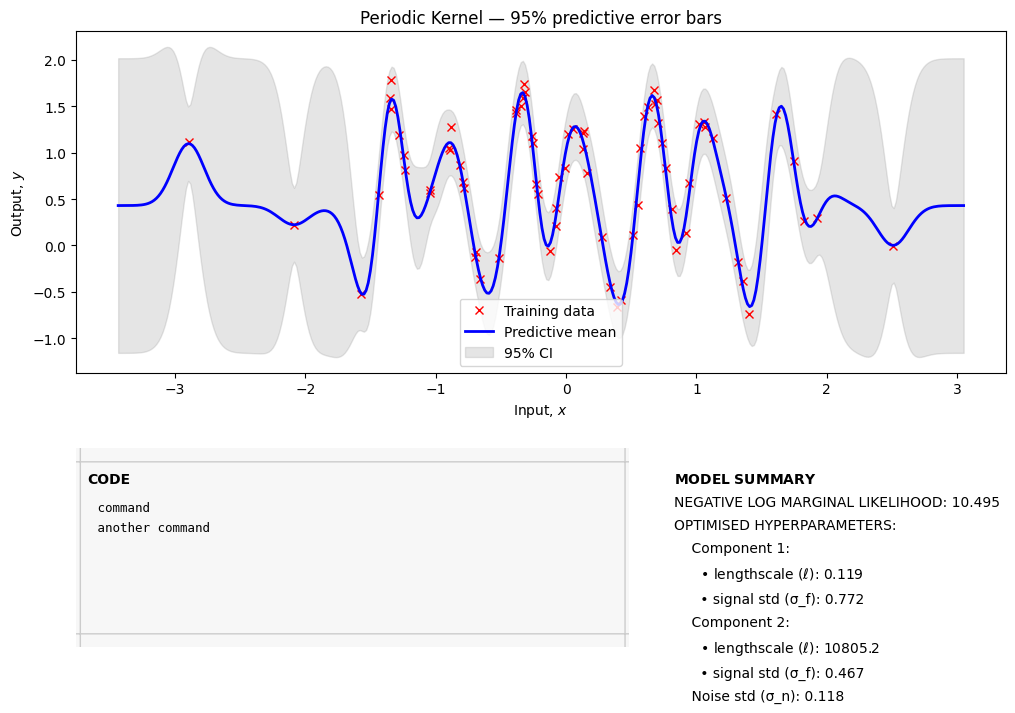

In [44]:
cw1utils.print_model_summary(m)
cw1utils.print_model_marginal_likelihood(m)
cw1utils.plot_predictive_error_bars(m, X, y, "\n command\n another command")

# cw1utils.plot_2d_predictive(mA, mB, codeA=None, codeB=None, save_path=None)
# cw1utils.plot_sampled_functions(X, F, code_snippet, n_draws=3, save_path=None)

# Now to the questions

## Question A

In [45]:
# loading the data

data = sio.loadmat("cw1a.mat")

X = np.asarray(data["x"], dtype=float)
y = np.asarray(data["y"], dtype=float)

#  Train a GP with a squared exponential covariance function, GPy.kern.RBF() and intialise the hyper parameters as described.

k = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)

m.Gaussian_noise.variance = 1.0

In [46]:
m.optimize()

In [47]:
print(m)


Name : GP regression
Objective : 78.22018820193148
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  0.4845011907029112  |      +ve      |        
  rbf.lengthscale          |   8.043570956727816  |      +ve      |        
  Gaussian_noise.variance  |  0.4396691697069872  |      +ve      |        


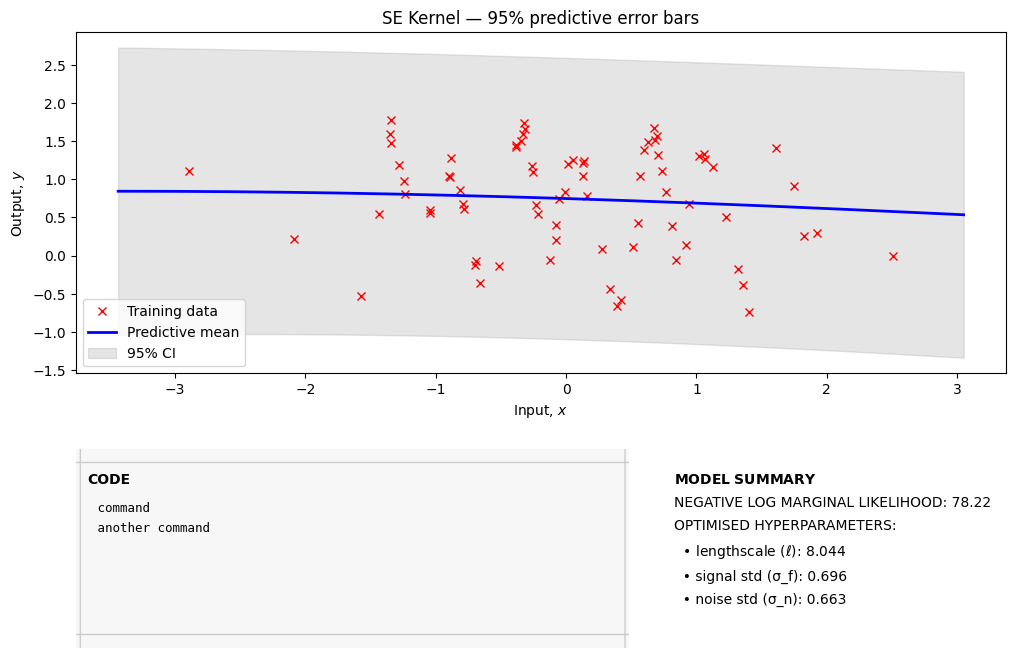

In [48]:
cw1utils.plot_predictive_error_bars(m, X, y, "\n command\n another command")

# Some preliminary observations for this part a

- The value $\ell = 8.044$ is very large compared to the overall input range (which goes from approximately $-3$ to $3$). This large value tells the model to be extremely confident that points far apart are still highly correlated. This forces the function to be incredibly smooth and almost linear/flat. The model is essentially ignoring any small wiggles in the data.

- The signal standard deviation (or kernel variance, $\sigma_f^2 \approx 0.485$) controls the overall magnitude of the function's variation. This relatively low value suggests the model believes the underlying function itself only varies by about $\pm 0.7$ units from its mean. It defines the vertical scale of the GP's prior belief, which is visible in the width of the confidence interval.

- The noise standard deviation (or noise variance, $\sigma_n^2 \approx 0.440$) estimates the measurement error in the data. The model has estimated a large amount of noise in the data, $\sigma_n \approx 0.663$. This value is very close to the signal standard deviation ($\sigma_f \approx 0.696$). When noise is nearly equal to the signal, the model struggles to distinguish between the true function and random error. This causes the predictive mean line to be very flat (it's aggressively smoothing the data), and the predictive error bars remain wide even near the data points.

- For the shape of the bar: Even where data points exist, the large noise estimate means the model is uncertain about the true function's value because it believes the observations are highly corrupted by noise. This keeps the bars wide everywhere. The extremely smooth nature (large $\ell$) means the model's uncertainty does not increase sharply as you move away from the data (as is typical for GPs). This keeps the width uniform.

- The model has decided the data is dominated by noise and that the underlying function is extremely simple (almost constant). The large lengthscale acts as a very strong prior, smoothing out all apparent structure in the data.